#### Load libraries

In [1]:
print('load libraries')
import xarray as xr
import numpy as np
import dask
from tqdm import tqdm
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import cftime

load libraries


In [21]:
fin_all_loop = """
███████╗██╗███╗   ██╗    ███████╗██╗███╗   ██╗    ███████╗██╗███╗   ██╗
██╔════╝██║████╗  ██║    ██╔════╝██║████╗  ██║    ██╔════╝██║████╗  ██║
█████╗  ██║██╔██╗ ██║    █████╗  ██║██╔██╗ ██║    █████╗  ██║██╔██╗ ██║
██╔══╝  ██║██║╚██╗██║    ██╔══╝  ██║██║╚██╗██║    ██╔══╝  ██║██║╚██╗██║
██║     ██║██║ ╚████║    ██║     ██║██║ ╚████║    ██║     ██║██║ ╚████║
╚═╝     ╚═╝╚═╝  ╚═══╝    ╚═╝     ╚═╝╚═╝  ╚═══╝    ╚═╝     ╚═╝╚═╝  ╚═══╝
"""

fin_for_loop = """
███████╗██╗███╗   ██╗
██╔════╝██║████╗  ██║
█████╗  ██║██╔██╗ ██║
██╔══╝  ██║██║╚██╗██║
██║     ██║██║ ╚████║
╚═╝     ╚═╝╚═╝  ╚═══╝
"""

In [4]:
xwmb.__version__, xwmt.__version__, xgcm.__version__

('0.1.0', '0.1.1', '0.8.2.dev15+g7492277')

#### Load and process data

In [5]:
hfdrake_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/data_daily/"
ds = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily.*.nc", chunks={"time":1})

In [6]:
snap = xr.open_mfdataset(f"{hfdrake_path}/*.ocean_daily_snap*.nc", chunks={"time":1})
static = xr.open_dataset("/pub/hfdrake/datasets/CM4_MHW_blobs/data/WMT_monthly/ocean_month_rho2.static.nc")#chunks={'time':1})

In [7]:
#Merge snapshots with time-averages
snap = snap.rename({
    **{'time': 'time_bounds'},
    **{v: f"{v}_bounds" for v in snap.data_vars}
    })

In [19]:
mt_path = "/pub/mariant3/WarmWaterMasses/notebooks/02_mhw_metrics/data_ocetrac-labels/"
blobs = xr.open_dataset(f"{mt_path}/01860503-01901020_ocetrac-labels-region.nc")
labels = blobs.blobs.rename('event_mask')
df = pd.read_pickle(f"{mt_path}/01860503-01901020_mhw-metrics-region.pkl")
df;

#### Beginning of analysis

In [9]:
ids = np.unique(labels)
ids = np.array([id for id in ids if ~np.isnan(id)])
ids

array([  3.,   6.,  22.,  25.,  26.,  32.,  34.,  35.,  36.,  37.,  40.,
        41.,  42.,  45.,  48.,  49.,  50.,  51.,  55.,  56.,  58.,  69.,
        71.,  74.,  75.,  78.,  79.,  80.,  84.,  86.,  87.,  88.,  89.,
        90.,  91.,  94.,  98.,  99., 101., 103., 112., 113., 116., 118.,
       119., 120., 122., 127., 128., 130., 132., 133., 143., 145., 146.,
       148., 153., 156., 158., 159., 171., 184., 186., 189., 190., 194.,
       201., 202., 208., 212., 220., 221., 223., 224., 226., 227., 228.,
       231., 237., 242., 244., 246., 247., 249., 252., 256.])

In [10]:
one_day_ids = df[df['duration'] == 1]['id'].tolist()
# Remove ids from the original labels array
ids = np.array([id for id in ids if id not in one_day_ids])
ids

array([  3.,   6.,  25.,  26.,  32.,  37.,  40.,  41.,  42.,  48.,  49.,
        50.,  51.,  58.,  69.,  71.,  74.,  78.,  79.,  80.,  84.,  86.,
        87.,  89.,  90.,  91.,  94.,  98.,  99., 101., 103., 112., 113.,
       116., 120., 122., 130., 132., 133., 143., 145., 148., 153., 156.,
       159., 171., 184., 186., 189., 201., 212., 220., 221., 223., 224.,
       226., 228., 231., 237., 242., 244., 246., 247., 256.])

In [20]:
for mhw in ids[28:]:
    print(f'...Working on event {mhw}')
    #print(end_loop_str)
    break

#print(end_str)

...Working on event 99.0


In [14]:
for mhw in ids[29:]:
    print(f'...Working on event {mhw}')
    mhw_df = df.loc[df.id==mhw]
    start_date_mhw = str(mhw_df['date'].values[0][0])
    end_date_mhw = str(mhw_df['date'].values[0][-1])
    
    print(f'Event {mhw} starts on {start_date_mhw} and ends on {end_date_mhw}')
    
    print('----------------- starting cumulative mask part -----------------')
    
    event = (labels == mhw).any("time")
    ds_event = xr.merge([ds, event], join="inner")
    ds_event = xr.merge([ds_event.sel(time=ds_event.time[1:]), snap])
    ds_event = xr.merge([static, ds_event], join='inner')

    def add_estimated_layer_interfaces(ds):
        return ds.assign_coords({"zi": xr.DataArray(
            np.concatenate([[0], 0.5*(ds.zl.values[1:]+ds.zl.values[0:-1]), [6000]]),
            dims=('zi',)
        )})
    
    ds_event = add_estimated_layer_interfaces(ds_event)
    
    print('----------------- Adding core coordinates of static to ds_event -----------------')

    ds_event = ds_event.assign_coords({
        "areacello": xr.DataArray(ds_event["areacello"].values, dims=('yh', 'xh',)), # Required for area-integration
        "lon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
        "lat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)), # Required for calculating density if not already provided!
        "xq": xr.DataArray(ds_event["xq"].values, dims=('xq',)),
        "yq": xr.DataArray(ds_event["yq"].values, dims=('yq',)),
        "deptho": xr.DataArray(ds_event["deptho"].values, dims=('yh', 'xh',)),
        "geolon": xr.DataArray(ds_event["geolon"].values, dims=('yh', 'xh',)),
        "geolat": xr.DataArray(ds_event["geolat"].values, dims=('yh', 'xh',)),
        "geolon_c": xr.DataArray(ds_event["geolon_c"].values, dims=('yq', 'xq',)),
        "geolat_c": xr.DataArray(ds_event["geolat_c"].values, dims=('yq', 'xq',)),
    })
    coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'}
    }
    metrics = {
        ('X','Y'): "areacello", # Required for area-integration
    }

    ds_event['tos'] = ds_event['thetao'].isel(zl=0)
    grid = xgcm.Grid(ds_event.copy(), coords=coords, metrics=metrics, boundary={'X':'extend', 'Y':'extend', 'Z':'extend'}, autoparse_metadata=False)
    wm = xwmt.WaterMass(grid)

    print('----------------- importing xbudget -----------------')
    
    import xbudget
    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly").copy()
    del budgets_dict['salt']['lhs']
    del budgets_dict['salt']['rhs']

    xbudget.collect_budgets(grid, budgets_dict)

    #print(budgets_dict)
    
    print('----------------- MANSO Region part, regionate -----------------')
    

    import numpy as np
    import regionate
    import matplotlib.pyplot as plt
    print(' manso_region part')
    name = "MANSO"
    lons = np.array([-138.,-120.,-100., -70., -70., -100., -120., -138.])
    lats = np.array([10., 10., 10., 10., 38., 38., 38., 38.])
    manso_region = regionate.GriddedRegion(name, lons, lats, grid)

    import warnings
    
    print('----------------- getting ready for xwmb.WaterMassBudget calculation -----------------')
    
    lam = "heat"
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        wmb = xwmb.WaterMassBudget(
            grid,
            budgets_dict,
            ds_event.event_mask
        )
        wmb.mass_budget(lam, greater_than=True, default_bins=True)
        wmtcalc = wmb.wmt
        wmtcalc
        
    #wmt_event = wmtcalc.where(
    #(wmtcalc.time > cftime.datetime(186, 7, 16, calendar="noleap")) &
   # (wmtcalc.time < cftime.datetime(186, 10, 1, calendar="noleap")), 0
    #   )

    wmt_event = wmtcalc.sel(time=slice(start_date_mhw,end_date_mhw))
    print(wmt_event.time)
    
    print('----------------- loading xwmb.WaterMassBudget calculation -----------------')
    wmt_mhw_event_full = wmt_event.load()
    print('done with wmt_event.load()')
    
    print('saving...')
    wmt_mhw_event_full.to_netcdf(f'/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/mhw_wmt_budget_{int(mhw)}_{start_date_mhw}-{end_date_mhw}.nc', mode='w')
    print(f'Saved mhw #{int(mhw)}!!')

    print(fin_for_loop)
print(fin_all_loop)

...Working on event 101.0
Event 101.0 starts on 0188-05-25 and ends on 0188-05-27
----------------- starting cumulative mask part -----------------
----------------- Adding core coordinates of static to ds_event -----------------
----------------- importing xbudget -----------------
----------------- MANSO Region part, regionate -----------------
 manso_region part
----------------- getting ready for xwmb.WaterMassBudget calculation -----------------


KeyError: 0

In [135]:
#loading the saved budgets
wmt = xr.open_dataset('/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/0186-wmt-daily.nc')
wmt6 = xr.open_dataset('/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/mhw_wmt_budget_6_0186-05-30-0186-06-11.nc')
wmt3 = xr.open_dataset('/pub/mariant3/WarmWaterMasses/notebooks/04_WMT-MHW/WMT_data/mhw_wmt_budget_3_0186-05-09-0186-05-24.nc')

In [5]:
#function for plotting

import matplotlib.pyplot as plt
import numpy as np
import cftime


def plot_wmt(wmt, thetao, time_slice=None, label='manso', figsize=(10, 3), vmin=None, vmax=None, xlim=None, ylim=None):
    """
    Plotting calculated wmt for a given region

    Parameters:
    - wmt
    - thetao: target temperature
    - time_slice: Optional. Write as ('start_date', 'end_date').
      If None, the entire time range will be plotted.
    - label (str): Optional. The label for the plot.
    - figsize (tuple): Optional. Size of the figure (width, height).
    - vmin (float): Optional. Minimum value for color scale.
    - vmax (float): Optional. Maximum value for color scale.

    Returns:
    None
    """
    wmt_sel = wmt.sel(thetao_l_target=thetao, method='nearest')
    
    if time_slice:
        wmt_sel = wmt_sel.sel(time=slice(time_slice[0], time_slice[1]))

    plt.figure(figsize=figsize)  
    
    (-wmt_sel.boundary_fluxes).plot(label='boundary fluxes')
    wmt_sel.mass_tendency.plot(label=r"$\partial_{t} \mathcal{M}$")
    (-wmt_sel.diffusion).plot(label=r"diffusion")
    wmt_sel.mass_source.plot(label=r"mass_source")
    wmt_sel.convergent_mass_transport.plot(label='advection')
    (-wmt_sel.spurious_numerical_mixing).plot(label='spurious mixing')

    plt.legend()
    plt.title(label)
    plt.grid(True, linewidth=0.2)
    
    if vmin is not None and vmax is not None:
        plt.ylim(vmin, vmax)
        
    plt.show()


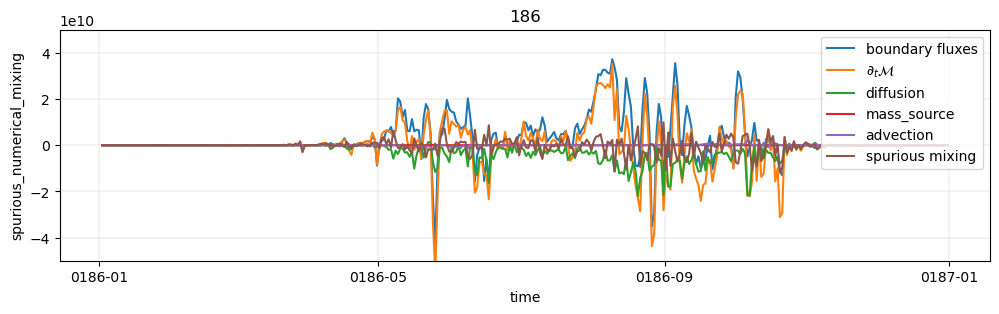

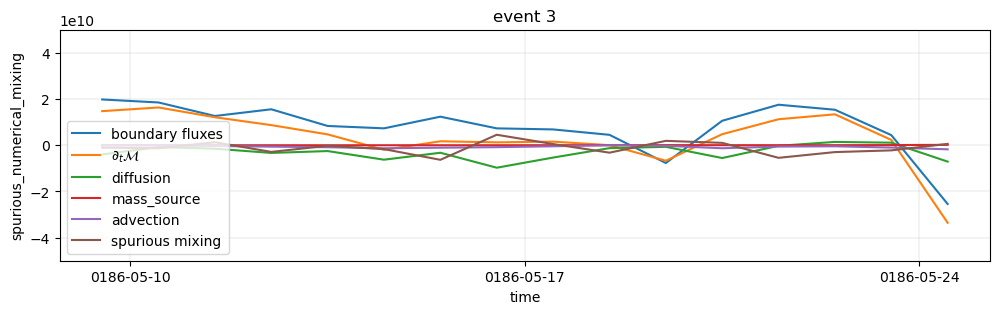

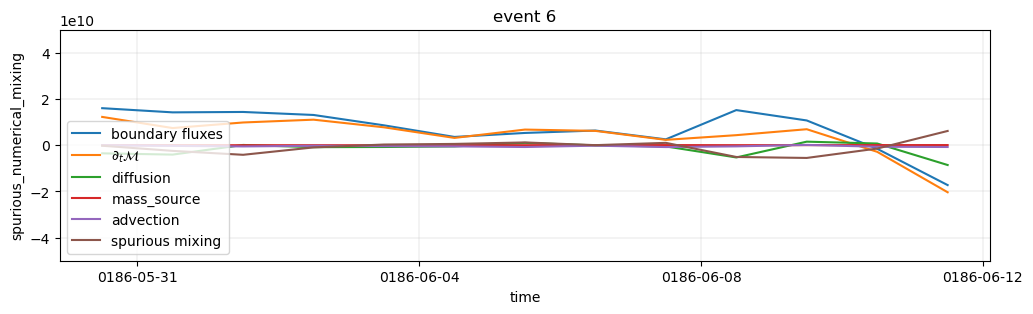

In [138]:
plot_wmt(wmt, thetao=29, label='186',time_slice=('0186','0186'),figsize=(12, 3),vmin=-5e+10, vmax=5e+10)
plot_wmt(wmt3, thetao=29, label='event 3',time_slice=('0186','0186'),figsize=(12, 3),vmin=-5e+10, vmax=5e+10)
plot_wmt(wmt6, thetao=29, label='event 6',time_slice=('0186','0186'),figsize=(12, 3),vmin=-5e+10, vmax=5e+10)